In [1]:
import pandas as pd
import numpy as np
from pykrige.rk import RegressionKriging
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
import joblib

# Leemos la data

Para la selección de variables predictoras armamos un csv con QGis con los departamentos dentro del AMBA y limitando a 100 por barrio, ya que el costo computacional del calculo de las distancias deseadas era muy alto.

In [4]:
df = pd.read_csv('csv/deptos_reducido.csv')

Nos quedamos con las columnas relevantes

In [5]:
df = df[["lat", "lon", "l3", "rooms", "bedrooms", "bathrooms", "surface_to", "surface_co", "distancia_subte", "distancia_tren", "dist_paradas_col", "dist_espacio_verde", "pm2"]]

Dropeamos NAs y corroboramos que no queden barrios en 0

In [6]:
df = df.dropna()
df.value_counts(subset=["l3"])

l3                  
Parque Centenario       94
Centro / Microcentro    82
Monte Castro            76
Once                    76
Villa Crespo            74
                        ..
Hurlingham              18
Villa Soldati           18
Malvinas Argentinas     16
Villa Riachuelo          4
Catalinas                1
Name: count, Length: 83, dtype: int64

## Entrenamiento del modelo de regresion

In [7]:
X = df[["rooms", "bedrooms", "bathrooms", "surface_to", "surface_co", "distancia_subte", "distancia_tren", "dist_paradas_col", "dist_espacio_verde"]].values
y = df["pm2"].values

In [8]:
# import Lasso
from sklearn.linear_model import Lasso

lr = Lasso()

In [9]:
lr.fit(X, y)

Lasso()

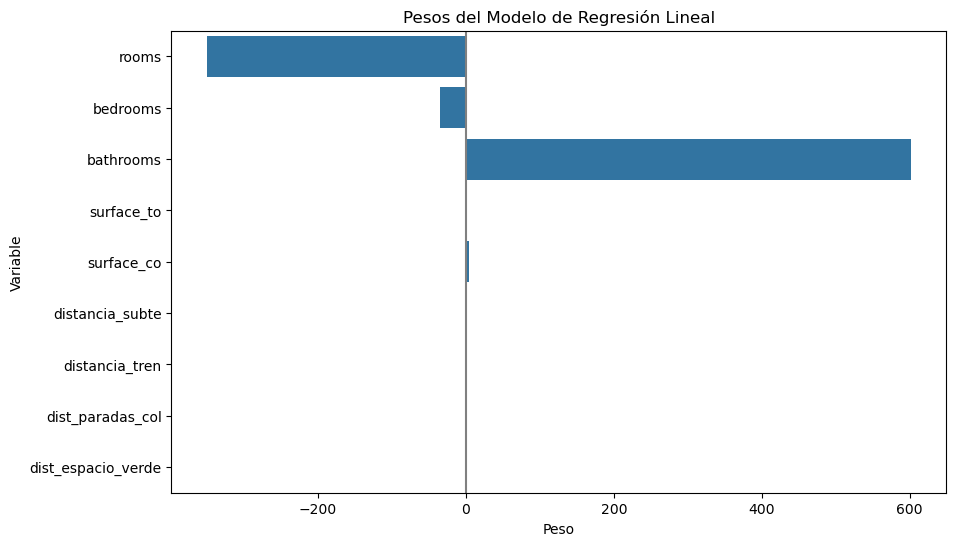

In [12]:
columnas = ["rooms", "bedrooms", "bathrooms", "surface_to", "surface_co", "distancia_subte", "distancia_tren", "dist_paradas_col", "dist_espacio_verde"]
df_coefs = pd.DataFrame({
    "feature": columnas,
    "coefficient": lr.coef_
})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_coefs, x="coefficient", y="feature")

plt.title("Pesos del Modelo de Regresión Lineal")
plt.xlabel("Peso")
plt.ylabel("Variable")
plt.axvline(0, color="grey", linestyle="-")
plt.savefig('plots/pesos_regresion_lineal.png')
plt.show()

Descartamos todo menos ambientes y baños.

## Volvemos a los datos completos

In [14]:
df = pd.read_csv('csv/deptos_amba.csv')

In [15]:
df.drop(df[df['bathrooms'] > 7].index, inplace=True)
df = df[df['bedrooms'] <= df['rooms']]

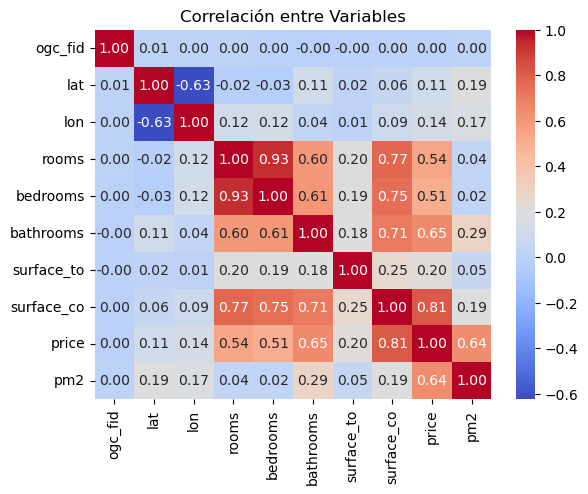

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre Variables");

como hay mucha correlacion entre bedrooms y rooms dropeamos la primera

In [18]:
df.drop(columns=['ogc_fid', 'price', 'surface_to', 'surface_co', 'bedrooms'], inplace=True)

In [19]:
df.isna().sum()

lat            0
lon            0
rooms          0
bathrooms    668
pm2            0
dtype: int64

In [20]:
df.dropna(inplace=True)

In [21]:
len(df)

33984

## grid search

In [12]:
param_grid = {
    'n_closest_points': [5, 10, 15],
    'l1_ratio': [0.1, 0.5, 0.9],
    'alpha': [0.1, 1, 10]
}

Tenemos que samplear porque la compu no puede con tantos datos.

In [14]:
df_sample = df.sample(n=15000, random_state=42)

x = df_sample[['lat', 'lon']].values
p = df_sample[['rooms', 'bathrooms']].values
target = df_sample['pm2'].values

x_train, x_test, p_train, p_test, target_train, target_test = train_test_split(x, p, target, test_size=0.3, random_state=42)

best_score = np.infty
best_params = None

for n_closest_points in param_grid['n_closest_points']:
    for l1_ratio in param_grid['l1_ratio']:
        for alpha in param_grid['alpha']:

            regression_model = ElasticNet(l1_ratio=l1_ratio, alpha=alpha)
            rk = RegressionKriging(
                regression_model=regression_model,
                n_closest_points=n_closest_points,
                variogram_model='gaussian',
                verbose=False
            )
            rk.fit(p, x, target)
            predictions = rk.predict(p_test, x_test)
            score = mean_absolute_error(target_test, predictions)
            if score < best_score:
                best_score = score
                best_params = {
                    'n_closest_points': n_closest_points,
                    'l1_ratio': l1_ratio,
                    'alpha': alpha
                    }

print(f"Mejor score: {best_score}")
print(f"Mejores parámetros: {best_params}")

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished

## Entrenamos el modelo seleccionado

In [22]:
x = df[['lat', 'lon']].values
p = df[['rooms', 'bathrooms']].values
target = df['pm2'].values

In [23]:
p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(p, x, target, test_size=0.4, random_state=42)

In [24]:
regression_model = ElasticNet(l1_ratio=0.1, alpha=10)
best_model = RegressionKriging(
    regression_model=regression_model,
    n_closest_points=5,
    weight=False,
    variogram_model='gaussian',
    verbose=True
)
best_model.fit(p_train, x_train, target_train)

Finished learning regression model
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 871015.527774664
Full Sill: 1150762.5233295006
Range: 0.0002487600593420899
Nugget: 279746.9955548365 

Calculating statistics on variogram model fit...
Finished kriging residuals


## Evaluamos

In [25]:
predictions = best_model.predict(p_test, x_test)

print('MAE:', mean_absolute_error(target_test, predictions))

Executing Ordinary Kriging...

MAE: 375.5093898732817


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

print('MSE:', mean_squared_error(target_test, predictions))
print('R2:', r2_score(target_test, predictions))

MSE: 367707.84806852124
R2: 0.6862455017907246


## Guardamos o cargamos según sea necesario

In [26]:
filename = 'rk_model.pkl'
joblib.dump(best_model, filename)

['rk_model.pkl']

In [3]:
best_model = joblib.load('rk_model.pkl')

# Prediccion para monoambientes

Leemos la grilla generada en QGIS

In [37]:
grid = pd.read_csv('csv/grilla_base.csv')

Calculamos el centro de cada casilla

In [38]:
grid['lat'] = grid['top'] - (grid['top'] - grid['bottom']) / 2
grid['lon'] = grid['right'] - (grid['right'] - grid['left']) / 2

In [39]:
x_new = grid[['lat', 'lon']].values

p para monoambientes

In [40]:
p_new = np.array([1, 1] * len(grid)).reshape(-1, 2)

Predecimos

In [41]:
predicciones = best_model.predict(p_new, x_new)

Executing Ordinary Kriging...



Guardamos predicciones a CSV

In [44]:
p_x_pred = np.concatenate((p_new, grid, predicciones.reshape(-1, 1)), axis=1)
p_x_pred = pd.DataFrame(p_x_pred, columns=['rooms', 'bathrooms', 'id', 'fid', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index', 'lat', 'lon', 'pm2'])
p_x_pred.to_csv('csv/pred_monoambientes.csv', index=False)

Cargamos esto en QGIS

Vectorial -> Herramientas de Análisis -> Contar Puntos en Poligono  
    Elegir la grilla y las predicciones
    Pesos = pm2

Hacemos intercepcion con AMBA con SQL y cargamos la capa

Exportamos capa a GeoPackage

Formateamos y listo.